In [2]:
# Setup

import math
import numpy.linalg as linalg
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List
from sklearn.datasets import fetch_openml

# Load MNIST dataset

mnist = fetch_openml(name='mnist_784', version=1)

images, labels = mnist.data, mnist.target

IMAGE_DIM: int = 28
DIGITS = 10

WRONG_ANSWER_VAL = 0
RIGHT_ANSWER_VAL = 1

def get_output_for_digit(digit: int) -> np.ndarray:
    arr = [WRONG_ANSWER_VAL for i in range(0, DIGITS)]
    arr[digit] = RIGHT_ANSWER_VAL
    return arr

def get_correct_digit(index: int) -> int:
    return int(labels[index])

def get_output_for_index(index: int) -> np.ndarray:
    return get_output_for_digit(get_correct_digit(index))

TOTAL_TRAINING_CASES = 70000
MAX_VAL = 256

datas = []
for i in range(0, TOTAL_TRAINING_CASES):
    datas.append(([v / MAX_VAL for v in images.iloc[i].values], get_output_for_digit(get_correct_digit(i))))

In [3]:
# Our neural network (iterative)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x)) 

class NeuralNetwork:

    layer_dimensions: List[int] = []
    inner_layers: int = 0
    learning_rate: float = 0

    weights: List[np.ndarray] = []
    biases: List[np.ndarray] = []

    def __init__(self, layer_dimensions: List[int], learning_rate: float):
        self.layer_dimensions = layer_dimensions
        self.inner_layers = len(layer_dimensions) - 1
        self.learning_rate = learning_rate

        self.randomize_parameters()
    
    def get_layer_dimension(self, dimension: int) -> int:

        return self.layer_dimensions[dimension]

    def randomize_parameters(self):
        
        self.weights = []
        self.biases = []

        for layer in range(1, self.inner_layers+1):

            last_dim = self.get_layer_dimension(layer - 1)
            this_dim = self.get_layer_dimension(layer)

            self.weights.append(np.random.randn(this_dim, last_dim))
            self.biases.append(np.random.randn(this_dim))

    def run(self, input: List[int]) -> List[int]:
        acc = input
        for layer in range(0, self.inner_layers):
            acc = sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc
    
    def run_to_layer(self, input: List[int], to_layer: int) -> List[int]:
        assert(to_layer <= self.inner_layers)
        acc = input
        for layer in range(0, to_layer):
            acc = sigmoid(self.weights[layer] @ acc + self.biases[layer])
        return acc

    def get_cost(self, inputs: List[int], expected_output: List[int]) -> float:
        return 0.5 * np.linalg.norm(self.run(inputs) - expected_output) ** 2

    def get_gradients_for(self, input: List[int], expected_output: List[int]) -> tuple[List[np.ndarray], List[np.ndarray]]:
        # forward propagation
        activations = []
        activation_primes = []
        acc = input
        for layer in range(0, self.inner_layers):
            activations.append(acc)

            mult = self.weights[layer] @ acc + self.biases[layer]
            acc = sigmoid(mult)
            activation_primes.append(sigmoid_prime(mult))
            
        activations.append(acc)

        residuals = activations[-1] - expected_output

        bias_gradients: List[np.ndarray] = [None] * self.inner_layers
        weight_gradients: List[np.ndarray] = [None] * self.inner_layers
        
        acc = residuals * activation_primes[self.inner_layers-1]
        for layer in range(self.inner_layers-1, -1, -1):

            bias_gradients[layer] = acc
            weight_gradients[layer] = np.outer(acc, activations[layer])

            if layer != 0: 
                acc = activation_primes[layer-1] * (self.weights[layer].transpose() @ acc)

        return (bias_gradients, weight_gradients)

    def train(self, input: List[int], expected_output: List[int]):

        gradients = self.get_gradients_for(input, expected_output)
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= self.learning_rate * gradients[0][layer]
            self.weights[layer] -= self.learning_rate * gradients[1][layer]
    
    def train_batch(self, inputs: List[List[float]], expected_outputs: List[List[float]]):
        batch_size = len(inputs)
        
        total_bias_gradients = [None] * self.inner_layers
        total_weight_gradients = [None] * self.inner_layers
        for i in range(0, batch_size):

            gradients = self.get_gradients_for(inputs[i], expected_outputs[i])
            
            if i == 0:
                total_bias_gradients = gradients[0]
                total_weight_gradients = gradients[1]
            else:
                for j in range(0, self.inner_layers):
                    total_bias_gradients[j] += gradients[0][j]
                    total_weight_gradients[j] += gradients[1][j]

        for i in range(0, self.inner_layers):        
            total_bias_gradients[i] *= self.learning_rate / batch_size
            total_weight_gradients[i] *= self.learning_rate / batch_size
        
        for layer in range(0, self.inner_layers):
            self.biases[layer] -= total_bias_gradients[layer]
            self.weights[layer] -= total_weight_gradients[layer]

In [4]:
TRAINING_ITERATIONS = 100
TRAINING_COUNT = 6000
BATCH_SIZE = 100
TEST_START = 60000
TEST_COUNT = 1000

network = NeuralNetwork([IMAGE_DIM*IMAGE_DIM, 16, 16, DIGITS], 1)

correct_percentage = [0]
for j in range(0, TRAINING_ITERATIONS):
    random.shuffle(datas)
    for i in range(0, TRAINING_COUNT, BATCH_SIZE):
        batch_in = [d[0] for d in datas[i:i+BATCH_SIZE]]
        batch_out = [d[1] for d in datas[i:i+BATCH_SIZE]]
        network.train_batch(batch_in, batch_out)

    total_correct = 0
    for i in range(TEST_START, TEST_START+TEST_COUNT):
        image = datas[i][0]

        result_raw = network.run(image)
        result = np.argmax(result_raw)
        
        if result == np.argmax(datas[i][1]):
            total_correct += 1

    correct_percentage.append(total_correct / TEST_COUNT * 100)
    print(str(total_correct / TEST_COUNT * 100) + '% correct')

19.5% correct
21.4% correct
26.1% correct
26.900000000000002% correct
31.7% correct
33.900000000000006% correct
35.6% correct
37.9% correct
42.5% correct
43.5% correct
46.5% correct
48.5% correct
49.1% correct
52.0% correct
52.800000000000004% correct
55.1% correct
56.00000000000001% correct
57.3% correct
60.3% correct
60.6% correct
63.2% correct
60.9% correct
64.7% correct
63.800000000000004% correct
66.60000000000001% correct
66.60000000000001% correct
66.7% correct
67.4% correct
69.69999999999999% correct
69.6% correct
69.8% correct
71.89999999999999% correct
72.39999999999999% correct
73.0% correct
73.1% correct
73.6% correct
74.0% correct
75.4% correct
75.3% correct
74.3% correct
76.7% correct
77.3% correct
76.7% correct
78.9% correct
78.60000000000001% correct
75.9% correct
77.10000000000001% correct
81.0% correct
80.5% correct
79.7% correct
80.10000000000001% correct
81.10000000000001% correct
78.60000000000001% correct
81.8% correct
79.80000000000001% correct
82.1% correct
81.0

/tmp/ipykernel_10378/354185110.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])


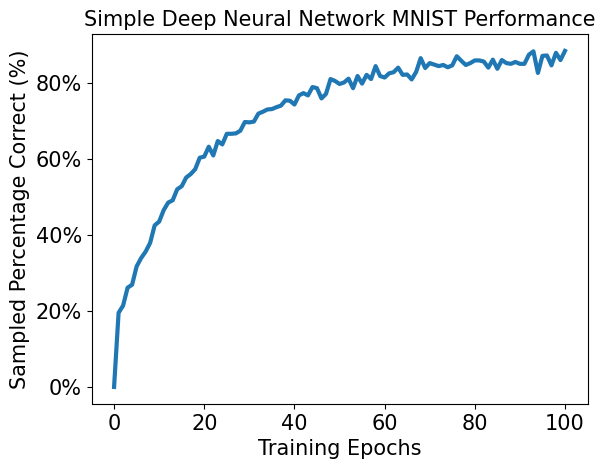

In [5]:
plt.plot(range(len(correct_percentage)), correct_percentage, linewidth=3)
plt.xlabel('Training Epochs', fontsize=15)
plt.ylabel('Sampled Percentage Correct (%)', fontsize=15)
plt.title('Simple Deep Neural Network MNIST Performance', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# Set y-axis ticks to display percentages from 0% to 100%
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show()